# Steps and tasks:

## 1. Read and explore the given dataset. (Rename column/add headers, plot histograms, find data characteristics)

In [1]:
# To enable plotting graphs in Jupyter notebook
%matplotlib inline 

In [2]:

#Import required libraries
import numpy as np
import pandas as pd
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.externals import joblib
import scipy.sparse
from scipy.sparse import csr_matrix
import warnings; warnings.simplefilter('ignore')

C:\Users\Neema MV\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [3]:
review_data = pd.read_csv('ratings_Electronics.csv', sep =',', names=['userId', 'productId','Rating','timestamp'])
review_data.head()

,userId,productId,Rating,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [4]:
#Check the number of rows and columns
rows, columns = review_data.shape
print("No. of rows:", rows)
print("No. of columns:", columns)

No. of rows: 7824482
No. of columns: 4


In [5]:
review_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 4 columns):
userId       object
productId    object
Rating       float64
timestamp    int64
dtypes: float64(1), int64(1), object(2)
memory usage: 238.8+ MB


In [6]:
# number of missing values (only the ones recognised as missing values) in each of the attributes
pd.DataFrame( review_data.isnull().sum(), columns= ['Number of missing values'])

,Number of missing values
userId,0
productId,0
Rating,0
timestamp,0


* There are no missing values

In [7]:
#Summary statistics od 'Rating' variable
review_data['Rating'].describe().transpose()

count    7.824482e+06
mean     4.012337e+00
std      1.380910e+00
min      1.000000e+00
25%      3.000000e+00
50%      5.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: Rating, dtype: float64

In [8]:
#find the min and max of the Ratings given
print('The minimum rating is : %d' %(review_data['Rating'].min()))
print('The maximum rating is : %d' %(review_data['Rating'].max()))


The minimum rating is : 1
The maximum rating is : 5


Ratings are on the scale 1-5

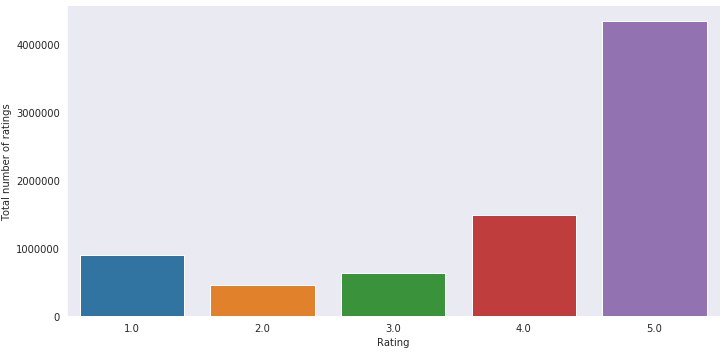

In [9]:
#Check the distribution of ratings
with sns.axes_style('dark'):
    g=sns.factorplot("Rating", data = review_data, aspect=2.0, kind='count')
    g.set_ylabels("Total number of ratings")

In [10]:
#Number of unique Users and products in the data
print('Number of unique USERS in the data: ', review_data['userId'].nunique())
print('Number of unique PRODUCTS in the data: ', review_data['productId'].nunique())

Number of unique USERS in the data:  4201696
Number of unique PRODUCTS in the data:  476002


# 2. Take a subset of the dataset to make it less sparse/ denser.  ( For example, keep the users only who has given 50 or  more number of ratings )

In [11]:
#Top 10 users based on rating
most_rated=review_data.groupby('userId').size().sort_values(ascending = False)[:20]
most_rated

userId
A5JLAU2ARJ0BO     520
ADLVFFE4VBT8      501
A3OXHLG6DIBRW8    498
A6FIAB28IS79      431
A680RUE1FDO8B     406
A1ODOGXEYECQQ8    380
A36K2N527TXXJN    314
A2AY4YUOX2N1BQ    311
AWPODHOB4GFWL     308
A25C2M3QF9G7OQ    296
ARBKYIVNYWK3C     296
A22CW0ZHY3NJH8    292
A3EXWV8FNSSFL6    282
A38RMU1Y5TDP9     282
A3LGT6UZL99IW1    279
A2NOW4U7W3F7RI    277
A23GFTVIETX7DS    270
A3PD8JD9L4WEII    266
A17BUUBOU0598B    261
A3AYSYSLHU26U9    257
dtype: int64

Data model preparation as per requirements on the number of minimum ratings

In [12]:
count = review_data['userId'].value_counts()
print('count \n', count)

count 
 A5JLAU2ARJ0BO     520
ADLVFFE4VBT8      501
A3OXHLG6DIBRW8    498
A6FIAB28IS79      431
A680RUE1FDO8B     406
                 ... 
A30YYSG88YXNZ1      1
A2ZB2MLUXZOW75      1
AUQDSEQXQS3F0       1
A36A6SRYJM2R4V      1
A3TBLAH6BAUZBH      1
Name: userId, Length: 4201696, dtype: int64


In [13]:
review_data_final = review_data[review_data['userId'].isin(count[count >= 308].index)]
review_data_final.head()

,userId,productId,Rating,timestamp
2162,A5JLAU2ARJ0BO,1400532655,1.0,1291334400
5195,A36K2N527TXXJN,9800359788,5.0,1367280000
5932,ADLVFFE4VBT8,9981719005,3.0,1238716800
7748,A680RUE1FDO8B,B000001OMI,5.0,1227744000
8732,A6FIAB28IS79,B00000J05A,3.0,985564800


In [14]:
review_data_final.shape

(3669, 4)

review_data_final has users who have rated more than 224 pr more times

Calculate the density of the rating matrix

In [15]:
final_rating_matrix = review_data_final.pivot(index='userId', columns='productId', values='Rating').fillna(0)
print('Shape of the final_rating_matrix: ', final_rating_matrix.shape)

#Non zero ratings
given_number_of_ratings = np.count_nonzero(final_rating_matrix)
print('given_number_of_ratings: ', given_number_of_ratings)

#Total possible ratings
possible_num_of_ratings = final_rating_matrix.shape[0] * final_rating_matrix.shape[1]
print('possible_num_of_ratings: ', possible_num_of_ratings)

#Density
density = (given_number_of_ratings/possible_num_of_ratings)
density *= 100
print('Density: {:4.2f}%'.format(density))


Shape of the final_rating_matrix:  (9, 3268)
given_number_of_ratings:  3669
possible_num_of_ratings:  29412
Density: 12.47%


In [16]:
final_rating_matrix.head()

productId,1400532655,9800359788,9981719005,B000001OMI,B00000J05A,B00000J1QS,B00000J1UQ,B00000J4CY,B00000JGNB,B00000JHX1,...,B00KINSDK8,B00KLGSQJ0,B00KNEBRT6,B00KVNY2KA,B00KWMNDDM,B00KYMCJF8,B00L1I80K2,B00L21HC7A,B00L26YDA4,B00L3YHF6O
userId,,,,,,,,,,,,,,,,,,,,,
A1ODOGXEYECQQ8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,5.0,0.0,5.0,5.0,0.0,5.0,3.0,0.0
A2AY4YUOX2N1BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A36K2N527TXXJN,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0
A3OXHLG6DIBRW8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A5JLAU2ARJ0BO,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
# Matrix with one row per Product and one column per user for item-based CF
final_rating_matrix_T = final_rating_matrix.transpose()
final_rating_matrix_T.head()

userId,A1ODOGXEYECQQ8,A2AY4YUOX2N1BQ,A36K2N527TXXJN,A3OXHLG6DIBRW8,A5JLAU2ARJ0BO,A680RUE1FDO8B,A6FIAB28IS79,ADLVFFE4VBT8,AWPODHOB4GFWL
productId,,,,,,,,,
1400532655,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
9800359788,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0
9981719005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0
B000001OMI,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0
B00000J05A,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0


# 3. Split the data randomly into train and test dataset. ( For  example, split it in 70/30 ratio)

In [19]:
#TRAIN AND TEST DATA
train_data, test_data = train_test_split(review_data_final, test_size = 0.3, random_state=0)
train_data.head()

,userId,productId,Rating,timestamp
1077229,AWPODHOB4GFWL,B000JE7GPY,5.0,1248393600
7800362,A1ODOGXEYECQQ8,B00ITI04YM,4.0,1401408000
2701169,A6FIAB28IS79,B002M78JA2,3.0,1306972800
712927,A5JLAU2ARJ0BO,B000ACAWZ6,1.0,1143504000
7819530,A36K2N527TXXJN,B00K6ZAKCW,4.0,1402444800


In [20]:
train_data.shape


(2568, 4)

In [21]:
test_data.shape

(1101, 4)

# 4. Build Popularity Recommender model.

In [22]:
#Count of user_id for each unique product as recommendation score 
train_data_grouped = train_data.groupby('productId').agg({'userId': 'count'}).reset_index()
train_data_grouped.rename(columns = {'userId': 'score'},inplace=True)
train_data_grouped.head()

,productId,score
0,1400532655,1
1,B000001OMI,1
2,B00000J1UQ,1
3,B00000J4CY,1
4,B00000JGNB,1


In [27]:
train_data

,userId,productId,Rating,timestamp
1077229,AWPODHOB4GFWL,B000JE7GPY,5.0,1248393600
7800362,A1ODOGXEYECQQ8,B00ITI04YM,4.0,1401408000
2701169,A6FIAB28IS79,B002M78JA2,3.0,1306972800
712927,A5JLAU2ARJ0BO,B000ACAWZ6,1.0,1143504000
7819530,A36K2N527TXXJN,B00K6ZAKCW,4.0,1402444800
...,...,...,...,...
847386,A6FIAB28IS79,B000EEQ83K,5.0,1200009600
7249140,AWPODHOB4GFWL,B00CELZD8C,5.0,1373500800
2152388,A3OXHLG6DIBRW8,B001MTE32O,4.0,1262476800
4903686,AWPODHOB4GFWL,B005FDXF2C,5.0,1364256000


In [33]:
#Sort the products on recommendation score 
train_data_sort = train_data_grouped.sort_values(['score', 'productId'], ascending = [0,1]) 
      
#Generate a recommendation rank based upon score 
train_data_sort['Rank'] = train_data_sort['score'].rank(ascending=0, method='first') 
          
#Get the top 5 recommendations 
popularity_recommendations = train_data_sort.head(5) 
popularity_recommendations 

,productId,score,Rank
1279,B002QEBMAK,4,1.0
1864,B0079UAT0A,4,2.0
2131,B00CSHCAVU,4,3.0
2136,B00CZDT30S,4,4.0
2142,B00D65AJ0C,4,5.0


In [34]:
# Use popularity based recommender model to make predictions
def recommend(user_id):     
    user_recommendations = popularity_recommendations 
          
    #Add user_id column for which the recommendations are being generated 
    user_recommendations['userId'] = user_id 
      
    #Bring user_id column to the front 
    cols = user_recommendations.columns.tolist() 
    cols = cols[-1:] + cols[:-1] 
    user_recommendations = user_recommendations[cols] 
          
    return user_recommendations 

In [36]:
find_recom = ['A6FIAB28IS79','AWPODHOB4GFWL']   # This list is user choice.
for i in find_recom:
    print("Here is the recommendation for the userId: %s\n" %(i))
    print(recommend(i))    
    print("\n") 

Here is the recommendation for the userId: A6FIAB28IS79

            userId   productId  score  Rank
1279  A6FIAB28IS79  B002QEBMAK      4   1.0
1864  A6FIAB28IS79  B0079UAT0A      4   2.0
2131  A6FIAB28IS79  B00CSHCAVU      4   3.0
2136  A6FIAB28IS79  B00CZDT30S      4   4.0
2142  A6FIAB28IS79  B00D65AJ0C      4   5.0


Here is the recommendation for the userId: AWPODHOB4GFWL

             userId   productId  score  Rank
1279  AWPODHOB4GFWL  B002QEBMAK      4   1.0
1864  AWPODHOB4GFWL  B0079UAT0A      4   2.0
2131  AWPODHOB4GFWL  B00CSHCAVU      4   3.0
2136  AWPODHOB4GFWL  B00CZDT30S      4   4.0
2142  AWPODHOB4GFWL  B00D65AJ0C      4   5.0




* Since this is a popularity-based recommender model, recommendations remain the same for all users

* We predict the products based on the popularity. It is not personalized to particular user

# 5. Build Collaborative Filtering model

In [37]:
df_CF = pd.concat([train_data, test_data]).reset_index()
df_CF.head()

,index,userId,productId,Rating,timestamp
0,1077229,AWPODHOB4GFWL,B000JE7GPY,5.0,1248393600
1,7800362,A1ODOGXEYECQQ8,B00ITI04YM,4.0,1401408000
2,2701169,A6FIAB28IS79,B002M78JA2,3.0,1306972800
3,712927,A5JLAU2ARJ0BO,B000ACAWZ6,1.0,1143504000
4,7819530,A36K2N527TXXJN,B00K6ZAKCW,4.0,1402444800


In [38]:
#User-based Collaborative Filtering
# Matrix with row per 'user' and column per 'item' 
pivot_df = df_CF.pivot(index = 'userId', columns ='productId', values = 'Rating').fillna(0)
pivot_df.shape
pivot_df.head()

productId,1400532655,9800359788,9981719005,B000001OMI,B00000J05A,B00000J1QS,B00000J1UQ,B00000J4CY,B00000JGNB,B00000JHX1,...,B00KINSDK8,B00KLGSQJ0,B00KNEBRT6,B00KVNY2KA,B00KWMNDDM,B00KYMCJF8,B00L1I80K2,B00L21HC7A,B00L26YDA4,B00L3YHF6O
userId,,,,,,,,,,,,,,,,,,,,,
A1ODOGXEYECQQ8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,5.0,0.0,5.0,5.0,0.0,5.0,3.0,0.0
A2AY4YUOX2N1BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A36K2N527TXXJN,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0
A3OXHLG6DIBRW8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A5JLAU2ARJ0BO,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [51]:
pivot_df

productId,1400532655,9800359788,9981719005,B000001OMI,B00000J05A,B00000J1QS,B00000J1UQ,B00000J4CY,B00000JGNB,B00000JHX1,...,B00KINSDK8,B00KLGSQJ0,B00KNEBRT6,B00KVNY2KA,B00KWMNDDM,B00KYMCJF8,B00L1I80K2,B00L21HC7A,B00L26YDA4,B00L3YHF6O
user_index,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,5.0,0.0,5.0,5.0,0.0,5.0,3.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,3.0,0.0,5.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,5.0
8,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,4.0,0.0,...,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0


In [39]:
pivot_df['user_index'] = np.arange(0, pivot_df.shape[0], 1)
pivot_df.head()

productId,1400532655,9800359788,9981719005,B000001OMI,B00000J05A,B00000J1QS,B00000J1UQ,B00000J4CY,B00000JGNB,B00000JHX1,...,B00KLGSQJ0,B00KNEBRT6,B00KVNY2KA,B00KWMNDDM,B00KYMCJF8,B00L1I80K2,B00L21HC7A,B00L26YDA4,B00L3YHF6O,user_index
userId,,,,,,,,,,,,,,,,,,,,,
A1ODOGXEYECQQ8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,5.0,0.0,5.0,5.0,0.0,5.0,3.0,0.0,0
A2AY4YUOX2N1BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
A36K2N527TXXJN,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,2
A3OXHLG6DIBRW8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
A5JLAU2ARJ0BO,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


In [40]:
pivot_df.set_index(['user_index'], inplace=True)

# Actual ratings given by users
pivot_df.head()

productId,1400532655,9800359788,9981719005,B000001OMI,B00000J05A,B00000J1QS,B00000J1UQ,B00000J4CY,B00000JGNB,B00000JHX1,...,B00KINSDK8,B00KLGSQJ0,B00KNEBRT6,B00KVNY2KA,B00KWMNDDM,B00KYMCJF8,B00L1I80K2,B00L21HC7A,B00L26YDA4,B00L3YHF6O
user_index,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,5.0,0.0,5.0,5.0,0.0,5.0,3.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# SVD 

In [52]:
from scipy.sparse.linalg import svds
# Singular Value Decomposition
U, sigma, Vt = svds(pivot_df, k = 8)
# Construct diagonal array in SVD
sigma = np.diag(sigma)

In [53]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 

# Predicted ratings
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = pivot_df.columns)
preds_df.head()

productId,1400532655,9800359788,9981719005,B000001OMI,B00000J05A,B00000J1QS,B00000J1UQ,B00000J4CY,B00000JGNB,B00000JHX1,...,B00KINSDK8,B00KLGSQJ0,B00KNEBRT6,B00KVNY2KA,B00KWMNDDM,B00KYMCJF8,B00L1I80K2,B00L21HC7A,B00L26YDA4,B00L3YHF6O
0,-0.007073,-0.508339,-0.035714,-0.039253,-0.028112,1.308380,-0.046853,-0.028112,1.308380,0.068316,...,1.635475,-0.406671,4.315763,-0.508339,4.315763,4.315763,-0.059524,4.315763,2.589458,1.575951
1,-0.000653,-0.046968,-0.003300,-0.003627,-0.002597,0.120887,-0.004329,-0.002597,0.120887,0.006312,...,0.151109,-0.037574,-0.063220,-0.046968,-0.063220,-0.063220,-0.005500,-0.063220,-0.037932,0.145609
2,-0.005254,4.622341,-0.026533,-0.029162,-0.020885,0.972032,-0.034808,-0.020885,0.972032,0.050754,...,1.215040,3.697873,-0.508339,4.622341,-0.508339,-0.508339,-0.044222,-0.508339,-0.305003,1.170818
3,0.000883,0.063442,0.004457,0.004899,0.003508,-0.163289,0.005847,0.003508,-0.163289,3.991474,...,-0.204112,0.050754,0.085395,0.063442,0.085395,0.085395,0.007429,0.085395,0.051237,-0.196683
4,0.999634,-0.026272,-0.001846,-0.002029,-0.001453,0.067620,-0.002421,-0.001453,0.067620,0.003531,...,0.084525,-0.021018,-0.035363,-0.026272,-0.035363,-0.035363,-0.003076,-0.035363,-0.021218,0.081449


In [54]:
# Recommend the items with the highest predicted ratings

def recommend_items(userID, pivot_df, preds_df, num_recommendations):
      
    user_idx = userID-1 # index starts at 0
    
    # Get and sort the user's ratings
    sorted_user_ratings = pivot_df.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_ratings
    sorted_user_predictions = preds_df.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_predictions

    temp = pd.concat([sorted_user_ratings, sorted_user_predictions], axis=1)
    temp.index.name = 'Recommended Items'
    temp.columns = ['user_ratings', 'user_predictions']
    
    temp = temp.loc[temp.user_ratings == 0]   
    temp = temp.sort_values('user_predictions', ascending=False)
    print('\nBelow are the recommended items for user(user_id = {}):\n'.format(userID))
    print(temp.head(num_recommendations))

In [58]:
#Enter 'userID' and 'num_recommendations' for the user #
userID = 9
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 9):

                   user_ratings  user_predictions
Recommended Items                                
B003ZBZ64Q                  0.0          2.850515
B00A35WYBA                  0.0          2.850515
B000VX6XL6                  0.0          2.797511
B001TH7GUK                  0.0          2.749782
B0053R0WWG                  0.0          2.731768


# 6. Evaluate both the models. ( Once the model is trained on  the training data, it can be used to compute the error  (RMSE) on predictions made on the test data.) 

In [59]:
# Actual ratings given by the users
final_rating_matrix.head()

productId,1400532655,9800359788,9981719005,B000001OMI,B00000J05A,B00000J1QS,B00000J1UQ,B00000J4CY,B00000JGNB,B00000JHX1,...,B00KINSDK8,B00KLGSQJ0,B00KNEBRT6,B00KVNY2KA,B00KWMNDDM,B00KYMCJF8,B00L1I80K2,B00L21HC7A,B00L26YDA4,B00L3YHF6O
userId,,,,,,,,,,,,,,,,,,,,,
A1ODOGXEYECQQ8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,5.0,0.0,5.0,5.0,0.0,5.0,3.0,0.0
A2AY4YUOX2N1BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A36K2N527TXXJN,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0
A3OXHLG6DIBRW8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A5JLAU2ARJ0BO,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [61]:
# Average ACTUAL rating for each item
final_rating_matrix.mean().head()

productId
1400532655    0.111111
9800359788    0.555556
9981719005    0.333333
B000001OMI    0.555556
B00000J05A    0.333333
dtype: float64

In [62]:
# Average PREDICTED rating for each item
preds_df.mean().head()

productId
1400532655    0.111437
9800359788    0.579006
9981719005    0.334981
B000001OMI    0.557366
B00000J05A    0.334630
dtype: float64

In [64]:
rmse_df = pd.concat([final_rating_matrix.mean(), preds_df.mean()], axis=1)
rmse_df.columns = ['Avg_actual_ratings', 'Avg_predicted_ratings']
print(rmse_df.shape)
rmse_df['item_index'] = np.arange(0, rmse_df.shape[0], 1)
rmse_df.head()

(3268, 2)


,Avg_actual_ratings,Avg_predicted_ratings,item_index
productId,,,
1400532655,0.111111,0.111437,0
9800359788,0.555556,0.579006,1
9981719005,0.333333,0.334981,2
B000001OMI,0.555556,0.557366,3
B00000J05A,0.333333,0.334630,4


In [65]:
RMSE = round((((rmse_df.Avg_actual_ratings - rmse_df.Avg_predicted_ratings) ** 2).mean() ** 0.5), 5)
print('\nRMSE SVD Model = {} \n'.format(RMSE))


RMSE SVD Model = 0.0224 



As you can the RSME is low, hence the model is giving better accurate results

# 7. Get top - K ( K = 5) recommendations. Since our goal is to  recommend new products for each user based on his/her  habits, we will recommend 5 new products. 

In [67]:
# Enter 'userID' and 'num_recommendations' for the user #
userID = 9
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 9):

                   user_ratings  user_predictions
Recommended Items                                
B003ZBZ64Q                  0.0          2.850515
B00A35WYBA                  0.0          2.850515
B000VX6XL6                  0.0          2.797511
B001TH7GUK                  0.0          2.749782
B0053R0WWG                  0.0          2.731768


# 8. Summarise your insights


#### User-based Collaborative Filtering is a personalised recommender system, the recommendations are based on the past behavior of the user and it is not dependent on any additional information.

#### The Popularity-based recommender system is non-personalised and the recommendations are based on frequecy counts, which may be not suitable to the user.You can see the differance above for the user id 'A6FIAB28IS79' & 'AWPODHOB4GFWL' , The Popularity based model has recommended the same set of 5 products to both but Collaborative Filtering based model has recommended entire different list based on the user past purchase history